# Análisis del riesgo de incumplimiento de los prestatarios

En este proyecto analisamos cuales pueden ser algunos de los factores que influyen en el incumplimiento de un crédito. Averiguaremos si el estado civil y el número de hijos de un cliente tienen un impacto en el incumplimiento de pago de un préstamo. Utilizaremos algunos datos sobre la solvencia crediticia de los clientes, que nos proporcionó el banco con el trabajamos.

El informe se tendrá en cuenta al crear una **puntuación de crédito** para un cliente potencial. La **puntuación de crédito** se utiliza para evaluar la capacidad de un prestatario potencial para pagar su préstamo.

**Descripción de los datos**
Trabajamos con una tabla con datos de los clientes a la que hemos tenido acceso. Las siguientes son las variables que se miden por cliente:

- `children` - el número de hijos en la familia
- `days_employed` - experiencia laboral en días
- `dob_years` - la edad del cliente en años
- `education` - la educación del cliente
- `education_id` - identificador de educación
- `family_status` - estado civil
- `family_status_id` - identificador de estado civil
- `gender` - género del cliente
- `income_type` - tipo de empleo
- `debt` - ¿había alguna deuda en el pago de un préstamo?
- `total_income` - ingreso mensual
- `purpose` - el propósito de obtener un préstamo

In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import math
# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y análisis
# ==============================================================================
import statsmodels.api as sm
from scipy import stats

# Configuración matplotlib
# ==============================================================================
plt.style.use('ggplot')
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_credit_scoring = pd.read_csv('credit_scoring_eng.csv')
data_credit_scoring.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [3]:
data_credit_scoring.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,bachelor's degree,0,married,0,F,employee,0,40620.102,purchase of the house
1,1,-4024.803754,36,secondary education,1,married,0,F,employee,0,17932.802,car purchase
2,0,-5623.422610,33,Secondary Education,1,married,0,M,employee,0,23341.752,purchase of the house
3,3,-4124.747207,32,secondary education,1,married,0,M,employee,0,42820.568,supplementary education
4,0,340266.072047,53,secondary education,1,civil partnership,1,F,retiree,0,25378.572,to have a wedding


***Primer vistazo a los datos***

De una revisión de las primeras 5 filas de la base de datos podemos identificamos algunos problemas con los datos: 

* En la columna `days_employed` la mayoría de los datos parecen ser negativos. Lo cual no tiene sentido por lo que mide la variable. 

* En `days_employed`, identificamos observaciones imposibles, por ejemplo, 340266.072047 días que representan más de 900 años, lo cual es evidentemente un error. 

* En la columna `education` hay filas que tienen cadenas de string en mayúsculas, otras que solo empiezan en mayúscula, etc. Se sugiere poner todas las cadenas en minúscula. 

***Comentarios sobre el tipo de datos***
1. Solo dos columnas presentan datos perdidos: `days_employed` y `total_income`. Estas son de tipo numérico. Ambas tienen la misma cantidad de datos perdidos, luego parece ser que los datos que faltan en ambas columnas se refieren a las mismas filas. Es decir, las personas que no respondieron a los días empleados tampoco pudieron responder el ingreso total. Debemos confirmar esta hipótesis.

2. El tipo de datos en `days_employed` es `float64`, lo lógico es que estos datos sean enteros. Además, las columnas `education_id`, `family_status_id` y `debt` aparecen como datos de tipo `int64`, aunque son variables categoricas. Evaluar si esto puede afectar al análisis que vamos hacer.  

In [4]:
data_credit_scoring['education'] = data_credit_scoring['education'].str.lower()
# hemos puesto en minúsculas todos los valores únicos de esta columna

In [5]:
data_employed_income = data_credit_scoring.loc[:,['days_employed', 'total_income']]
data_employed_income.isna().sum()

days_employed    2174
total_income     2174
dtype: int64

In [6]:
data_employed_income[data_employed_income['days_employed'].isna()].head(10)

,days_employed,total_income
12,NaN,NaN
26,NaN,NaN
29,NaN,NaN
41,NaN,NaN
55,NaN,NaN
65,NaN,NaN
67,NaN,NaN
72,NaN,NaN
82,NaN,NaN
83,NaN,NaN


La cantidad de datos faltantes es la misma en ambas columnas. Además, observando las 10 primera filas vemos que estos valores ausentes están presentes en ambas columnas a la vez. 

En otras palabras, `2174` personas encuestadas no aportaron datos sobre los días que llevan empleados ni sobre su ingreso total. Una primera **hipótesis** para explicar esto sería que estas personas perciben que sus ingresos y su antiguedad no son suficientes para que sea aprovada su solicitud de crédito, luego han decidido no dar información. Si nos fijamos solo en el total de ingresos, hay varias caraterísticas del solicitante, que son medidas en la tabla, que tienen diferentes niveles de influencia en el total de ingresos. En este caso estás columnas serían: `gender`, `education`, `income_type` y `dob_years`. En efecto, por regla general las mujeres tienen menos ingresos que los hombres, además, el nivel educacional y el tipo de empleo influyen directamente en la cantidad de ingresos, así como la edad la edad indirectamente también.

In [7]:
def group_age(age):
    if 0 <= age < 10:
        return '0-9'
    elif 10 <= age < 20:
        return '10-19'
    elif 20 <= age < 30:
        return '20-29'
    elif 30 <= age < 40:
        return '30-39'
    elif 40 <= age < 50:
        return '40-49'
    elif 50 <= age < 60:
        return '50-59'
    elif 60 <= age < 70:
        return '60-69'
    elif age >= 70:
        return '70+'
data_credit_scoring['age_group'] = data_credit_scoring['dob_years'].apply(group_age)

Hemos creado una nueva columna, `age_group`, para describir la distribución el ingreso total por grupos de edad. 

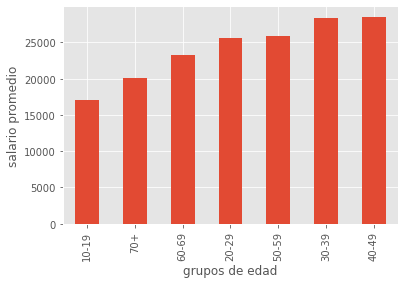

In [9]:
data_credit_scoring.groupby('age_group')['total_income'].mean().drop(index = ['0-9']).sort_values().plot(kind = 'bar')
plt.xlabel('grupos de edad')
plt.ylabel('salario promedio')
plt.show()

Los grupos etarios que perciben mayores ingresos promedio son los grupos de `30-39` y `40-49` con medias de `28 312` y `28 551`, las cuales están por encima de la media y la mediana globales. 

In [10]:
data_filtered = data_credit_scoring.query('days_employed.isna() and total_income.isna()')

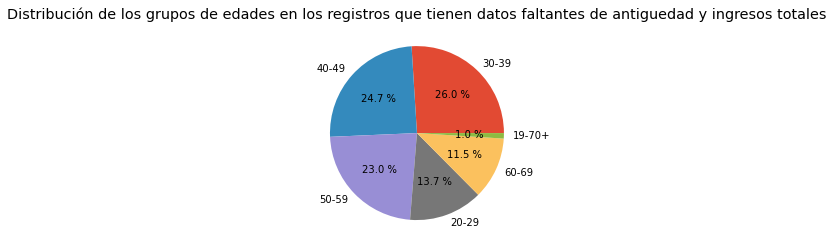

In [11]:
data = data_filtered['age_group'].value_counts()
data = data.loc['30-39':'60-69'].append(pd.Series(data = [data['70+'] + data['0-9'] + data['10-19']], index = ['19-70+']))
plt.pie(data, labels = data.index, autopct="%0.1f %%")
plt.title('Distribución de los grupos de edades en los registros que tienen datos faltantes de antiguedad y ingresos totales')
plt.show()

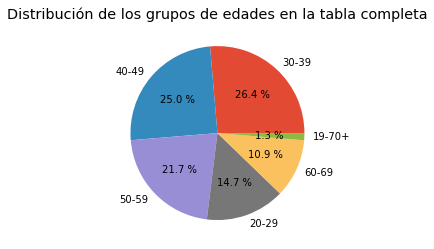

In [12]:
data = data_credit_scoring['age_group'].value_counts()
data = data.loc['30-39':'60-69'].append(pd.Series(data = [data['70+'] + data['0-9'] + data['10-19']], index = ['19-70+']))
plt.pie(data, labels = data.index, autopct="%0.1f %%")
plt.title('Distribución de los grupos de edades en la tabla completa')
plt.show()

Cuando hacemos un análisis de la distribución de los grupos de edad en la tabla completa y en la tabla filtrada se puede observar que hay una ligera diferencia de las distribuciones entre estos dos datasets. Los grupos de edad `50-59` y `20-29` son más frecuentes en la tabla filtrada.



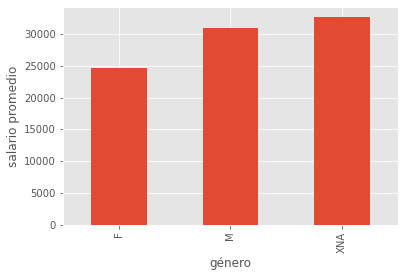

In [13]:
data_credit_scoring.groupby('gender')['total_income'].mean().plot(kind = 'bar')
plt.ylabel('salario promedio')
plt.xlabel('género')
plt.show()

El ingreso medio de las mujeres es `1.25` veces menor que el de los hombres. El salario medio de las mujeres está por debajo de la media global y apenas un poco por encima de la mediana goblal. 

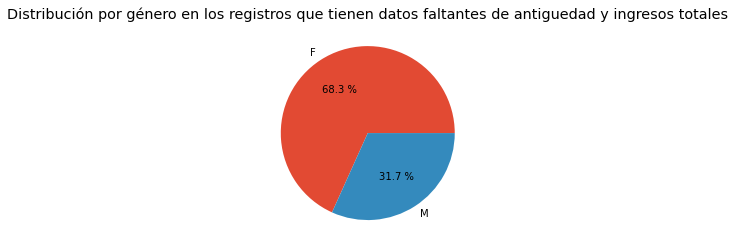

In [14]:
filtered_frec_gender = data_filtered['gender'].value_counts()
plt.pie(filtered_frec_gender, labels = filtered_frec_gender.index, autopct="%0.1f %%")
plt.title('Distribución por género en los registros que tienen datos faltantes de antiguedad y ingresos totales')
plt.show()

Note que en el conjunto de datos filtrados hay dos veces más mujeres que hombres. Veamos la distribución por genero en la tabla completa. 

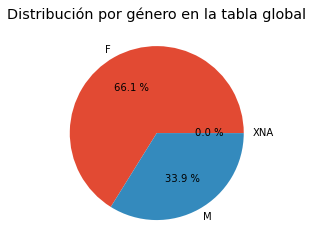

In [15]:
global_frec_gender = data_credit_scoring['gender'].value_counts()
plt.pie(global_frec_gender, labels = global_frec_gender.index, autopct="%0.1f %%")
plt.title('Distribución por género en la tabla global')
plt.show()

El `68%` de los encuestados en la tabla filtrada son mujeres. En la tabla global, el `66%` son mujeres. 

***En la tabla filtrada hay un 2% más mujeres que en la tabla global.*** 

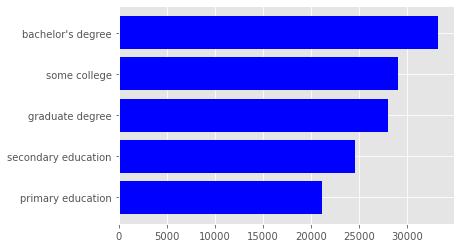

In [16]:
data = data_credit_scoring.groupby('education')['total_income'].mean().sort_values()
plt.barh(data.index, data, color = 'blue')
plt.show()

**Existen diferencias del ingreso promedio entre las diferentes categorías educativas**, siendo que la categoría de `primary education` es la de menor ingreso medio con `21 144` y `bachelor's degree` la de mayor ingreso medio con `33 142`. Vamos analizar la distribución de estas categorías en la tabla filtrada. 

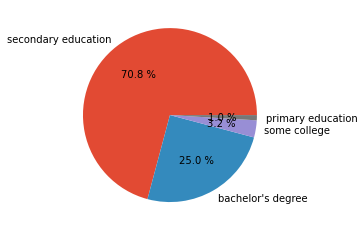

In [17]:
data = data_filtered['education'].value_counts()
plt.pie(data, labels = data.index, autopct="%0.1f %%")
plt.show()

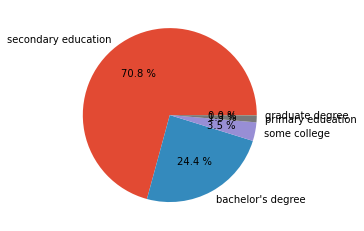

In [18]:
data = data_credit_scoring['education'].value_counts()
plt.pie(data, labels = data.index, autopct="%0.1f %%")
plt.show()

La frecuencia porcentual por nivel educativo no varia significativamente en los datos globales con respecto a la tabla filtrada.

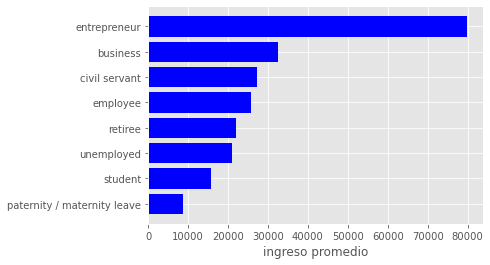

In [19]:
data = data_credit_scoring.groupby('income_type')['total_income'].mean().sort_values()
plt.barh(data.index, data, color = 'blue')
plt.xlabel('ingreso promedio')
plt.show()

De nuevo, **existen diferencias sustanciales del ingreso medio entre los diferentes tipos de ingresos.** La categoría `paternity / maternity leave` presenta el menor ingreso medio con `8 612` y la categoría `entrepreneur` presenta el máximo ingreso medio, con una diferencia sustancial con el segundo lugar de `79 866`. 

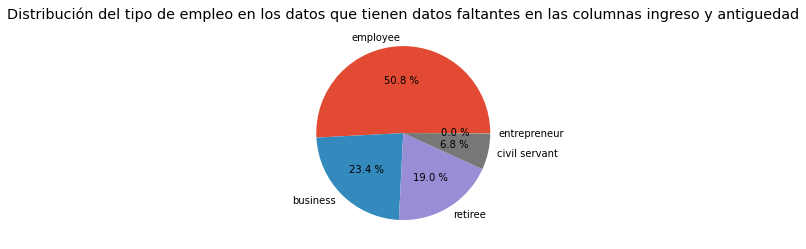

In [20]:
filtered_frec_income_type = data_filtered['income_type'].value_counts()
plt.pie(filtered_frec_income_type, labels = filtered_frec_income_type.index, autopct="%0.1f %%")
plt.title('Distribución del tipo de empleo en los datos que tienen datos faltantes en las columnas ingreso y antiguedad')
plt.show()

Aquí los encuestados que están en la categoría de empleados son los que más aparecen en la tabla filtrada con el `50.8%`de los datos y con un ingreso promedio de casi `26 000` más cercano a la media global y por encima de la mediana global. Los segundos son los que están en la categoría `bussiness`, seguidos por la categoría `retiree`.

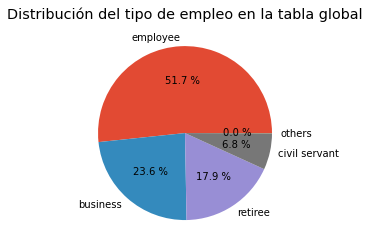

In [21]:
data = data_credit_scoring['income_type'].value_counts()
data = data.loc['employee':'civil servant'].append(pd.Series(data = [data['unemployed'] + data['entrepreneur'] + data['student'] + data['paternity / maternity leave']], index = ['others']))
plt.pie(data, labels = data.index, autopct="%0.1f %%")
plt.title('Distribución del tipo de empleo en la tabla global')
plt.show()

Los empleados son la categoría que más se repite tanto en los datos globales, siendo `1.6%` más frecuente que en la tabla filtrada. Los emprendedores aunque son los que más ingresos totales perciben, es una categoría con muy pocos elementos.

### Conclusiones parciales de este estudio

* Existen diferencias sustanciales entre los ingresos medios de las categorías: `gender`, `education`, `income_type` y `age_group`.

* Las `mujeres` son un `2%` más frecuentes en la tabla filtrada y los grupos de edades de `30-49` son menos frecuentes en la tabla filtrada. En otras palabras, las categorías con menos ingresos parecen ser ligeramente más frecuentres en las tabla filtrada. **Esto podría tomarse como una evidencia de que los datos faltantes están asociados a ingresos más bajos.**

## Transformación de datos

Vamos a ir columna por columna en donde existen valores no válidos. En esta sección, también vamos a resolver el tema de los duplicados. 

In [22]:
data_credit_scoring['education'].unique()

array(["bachelor's degree", 'secondary education', 'some college',
       'primary education', 'graduate degree'], dtype=object)

In [23]:
education_correct_values = ["bachelors's_degree", "secondary_education", 
                           "some_college", "primary_education", "graduate_degree"]
education_wrong_values = ["bachelor's degree", 'secondary education', 'some college',
       'primary education', 'graduate degree']
for i in range(len(education_correct_values)):
    data_credit_scoring['education'] = data_credit_scoring['education'].replace(education_wrong_values[i], education_correct_values[i])

data_credit_scoring['education'].unique()

array(["bachelors's_degree", 'secondary_education', 'some_college',
       'primary_education', 'graduate_degree'], dtype=object)

Hemos solucionado el problema de la existencia de valores repetidos debido a las mayúscular en la columana `education`.

In [24]:
data_credit_scoring['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5], dtype=int64)

Cuando mostramos los valores únicos de la columna `children` vemos que existen filas con el valor `-1`, lo que es un valor inválido para el número de hijos. **Arreglamos este problema sustituyendo la columna por su valor absoluto. Con esto eliminamos los valores negativos.**

In [25]:
data_credit_scoring['children'] = abs(data_credit_scoring['children'])

In [30]:
len_children_20 = len(data_credit_scoring[data_credit_scoring['children'] == 20])
len_children_20

76

La cantidad de clientes con 20 hijos es 76, estos clientes pueden haber querido poner 2 o 0 hijos. 

In [32]:
data_filtered_0_2 = data_credit_scoring.loc[(data_credit_scoring['children'] == 0) | (data_credit_scoring['children'] == 2)]
dis = round(data_filtered_0_2['children'].value_counts()/len(data_filtered_0_2)*100)
dis

0    87.0
2    13.0
Name: children, dtype: float64

Si nos fijamos en los encuestados con 0 o 2 hijos, la distribución: el `87%` no tiene hijos y el `13%` tiene dos hijos. Vamos a tomar una partición aleatoria de las filas con `20` hijos y vamos a corregir el dato con 0 o 2 siguiendo la distribución anterior. 

In [33]:
data_filtered_20 = data_credit_scoring[data_credit_scoring['children'] == 20]
partition = 0.87 
data_filtered_20['ramdom_partition'] = np.random.uniform(0, 1, len(data_filtered_20)) <= partition

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group,ramdom_partition
606,20,-880.221113,21,secondary_education,1,married,0,M,business,0,23253.578,purchase of the house,20-29,True
720,20,-855.595512,44,secondary_education,1,married,0,F,business,0,18079.798,buy real estate,40-49,True
1074,20,-3310.411598,56,secondary_education,1,married,0,F,employee,1,36722.966,getting an education,50-59,True
2510,20,-2714.161249,59,bachelors's_degree,0,widow / widower,2,F,employee,0,42315.974,transactions with commercial real estate,50-59,True
2941,20,-2161.591519,0,secondary_education,1,married,0,F,employee,0,31958.391,to buy a car,0-9,False
3302,20,NaN,35,secondary_education,1,unmarried,4,F,civil servant,0,NaN,profile education,30-39,True
3396,20,NaN,56,bachelors's_degree,0,married,0,F,business,0,NaN,university education,50-59,True
3671,20,-913.161503,23,secondary_education,1,unmarried,4,F,employee,0,16200.879,buying a second-hand car,20-29,True
3697,20,-2907.910616,40,secondary_education,1,civil partnership,1,M,employee,0,18460.911,buying a second-hand car,40-49,True
3735,20,-805.044438,26,bachelors's_degree,0,unmarried,4,M,employee,0,21952.103,housing renovation,20-29,True


In [34]:
data_credit_scoring.loc[data_filtered_20[data_filtered_20['ramdom_partition'] == True].index, 'children'] = 0
data_credit_scoring.loc[data_filtered_20[data_filtered_20['ramdom_partition'] == False].index, 'children'] = 2
data_credit_scoring['children'].unique()

array([1, 0, 3, 2, 4, 5], dtype=int64)

Hemos resuelto el problema de las filas que tenían `20` hijos siguiendo el procedimiento que habíamos planteado. 

In [35]:
data_days_employed_filtered = data_credit_scoring[data_credit_scoring['days_employed'] >= 300000]
print(len(data_days_employed_filtered))
print()
print(data_days_employed_filtered['dob_years'].mean())
print()
print(data_days_employed_filtered['income_type'].value_counts())

3445

59.12481857764877

retiree       3443
unemployed       2
Name: income_type, dtype: int64


In [36]:
data_days_employed_filtered_2 = data_credit_scoring[data_credit_scoring['days_employed'] < 0]
print(len(data_days_employed_filtered_2))

15906


En la columna `days_employed` hemos identificado dos tipos de valores inválidos:

* En primer lugar, `15906` filas que tienen valores negativos. Este problema podemos resolverlo tomando el valor absoluto de la columna.

* En segundo lugar, `3445` filas que tienen valores mayores a `300000` días, lo que representa más de `820` años antiguedad. Evidentemente, estos son datos erróneos. De estos `3445` encuestados, `3443` son `retirados` y solo dos están en la categoría de `desempleados`. Además, el promedio de edad en este grupo es de `59` años. Nosotros postulamos que esto se debe a un error humano en el cálculo de la antiguedad. Es probable que los encuestados esten dando los datos en `horas` y **no** en `días`. 

In [37]:
list_div = [8750]*len(data_days_employed_filtered)
data_credit_scoring.loc[data_credit_scoring['days_employed'] >= 300000,'days_employed'] = data_credit_scoring.loc[data_credit_scoring['days_employed'] >= 300000,'days_employed'].div(list_div)*365
data_credit_scoring['days_employed'] = abs(data_credit_scoring['days_employed'])
print(data_credit_scoring.head(10))

   children  days_employed  dob_years            education  education_id  \
0         1    8437.673028         42   bachelors's_degree             0   
1         1    4024.803754         36  secondary_education             1   
2         0    5623.422610         33  secondary_education             1   
3         3    4124.747207         32  secondary_education             1   
4         0   14193.956148         53  secondary_education             1   
5         0     926.185831         27   bachelors's_degree             0   
6         0    2879.202052         43   bachelors's_degree             0   
7         0     152.779569         50  secondary_education             1   
8         2    6929.865299         35   bachelors's_degree             0   
9         0    2188.756445         41  secondary_education             1   

       family_status  family_status_id gender income_type  debt  total_income  \
0            married                 0      F    employee     0     40620.102   
1

Hemos resuelto el problema de los valores `negativos` y de los valores mayores de `300 000` días de empleado.

In [38]:
print(sorted(data_credit_scoring['dob_years'].unique()))
print()
data_filtered_age = data_credit_scoring[data_credit_scoring['dob_years'] == 0]
print(data_filtered_age.head(10))
print()
print('La cantidad de filas con edad 0 es: ' + str(len(data_filtered_age)))
print()
print(data_credit_scoring.groupby('income_type')['dob_years'].mean())
print()
mean_by_type = data_credit_scoring.groupby('income_type')['dob_years'].mean()

[0, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]

      children  days_employed  dob_years            education  education_id  \
99           0   14455.736102          0  secondary_education             1   
149          0    2664.273168          0  secondary_education             1   
270          3    1872.663186          0  secondary_education             1   
578          0   16596.302426          0  secondary_education             1   
1040         0    1158.029561          0   bachelors's_degree             0   
1149         0     934.654854          0  secondary_education             1   
1175         0   15470.973762          0  secondary_education             1   
1386         0    5043.219890          0   bachelors's_degree             0   
1890         0            NaN          0   bachelors's_d

Podemos ver que hay `101` encuestados que tienen el dato de edad en `0`. Lo cual es un error a la hora de llenar los datos. Esto lo vamos a tratar como datos faltantes. Vamos a rellenarlos teniendo en cuenta la media por grupos de tipos de ingresos. 

In [39]:
def fill_age(row):
    age = row['dob_years']
    type_income = row['income_type']
    if age == 0:
        return int(mean_by_type[type_income])
    return age
# row_values = [0, 'retiree']
# row_columns = ['dob_years', 'income_type']
# row = pd.Series(data = row_values, index = row_columns)
# print(fill_age(row))

data_credit_scoring['dob_years'] = data_credit_scoring.apply(fill_age, axis = 1)

In [40]:
data_credit_scoring['dob_years'].unique().min()


19

Hemos resuelto el problema de edad con valor `0` en algunas filas.

In [41]:
data_credit_scoring['family_status'].unique()

array(['married', 'civil partnership', 'widow / widower', 'divorced',
       'unmarried'], dtype=object)

In [42]:
data_credit_scoring['family_status'] = data_credit_scoring['family_status'].replace('civil partnership', 'civil_partnership')
data_credit_scoring['family_status'] = data_credit_scoring['family_status'].replace('widow / widower', 'widow/widower')
data_credit_scoring['family_status'].unique()

array(['married', 'civil_partnership', 'widow/widower', 'divorced',
       'unmarried'], dtype=object)

Pusimos todos los valores de la columna `family_status` en el formato `snake_case`. Además, eliminamos los espacios en los nombres de las categorías.  

In [43]:
print(data_credit_scoring['gender'].unique())

data_credit_scoring['gender'].value_counts()

['F' 'M' 'XNA']


F      14236
M       7288
XNA        1
Name: gender, dtype: int64

**No parecen haber problemas significativos en la columna `gender`**

In [44]:
print(data_credit_scoring['income_type'].unique())
print()
data_credit_scoring['income_type'].value_counts()

['employee' 'retiree' 'business' 'civil servant' 'unemployed'
 'entrepreneur' 'student' 'paternity / maternity leave']



employee                       11119
business                        5085
retiree                         3856
civil servant                   1459
unemployed                         2
entrepreneur                       2
student                            1
paternity / maternity leave        1
Name: income_type, dtype: int64

In [45]:
data_credit_scoring['income_type'] = data_credit_scoring['income_type'].replace('paternity / maternity leave', 'paternity/maternity_leave')
data_credit_scoring['income_type'].unique()

array(['employee', 'retiree', 'business', 'civil servant', 'unemployed',
       'entrepreneur', 'student', 'paternity/maternity_leave'],
      dtype=object)

Pusimos todos los valores de la columna `income_type` en el formato `snake_case`. Además, eliminamos los espacios en los nombres de las categorías. 

In [46]:
print(data_credit_scoring.duplicated().sum())
data_credit_scoring = data_credit_scoring.drop_duplicates().reset_index(drop = True)
data_credit_scoring.duplicated().sum()

71


0

Habían `71` duplicados totales, los cuales hemos eliminado.

In [47]:
data_credit_scoring.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21454 entries, 0 to 21453
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21454 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21454 non-null  int64  
 3   education         21454 non-null  object 
 4   education_id      21454 non-null  int64  
 5   family_status     21454 non-null  object 
 6   family_status_id  21454 non-null  int64  
 7   gender            21454 non-null  object 
 8   income_type       21454 non-null  object 
 9   debt              21454 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21454 non-null  object 
 12  age_group         21454 non-null  object 
dtypes: float64(2), int64(5), object(6)
memory usage: 2.1+ MB


<div class="alert alert-block alert-success">
    
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Buen trabajo. Solo algunos puntos a fortalecer.
</div>

## Trabajar con los valores ausentes

### 3.1 Restaurar los valores ausentes en `total_income`

In [48]:
# Crea una tabla sin valores ausentes y muestra algunas de sus filas para asegurarte de que se ve bien
data_outna = data_credit_scoring.dropna()
data_outna.info()
print()
data_outna.head(15)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19351 entries, 0 to 21453
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          19351 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         19351 non-null  int64  
 3   education         19351 non-null  object 
 4   education_id      19351 non-null  int64  
 5   family_status     19351 non-null  object 
 6   family_status_id  19351 non-null  int64  
 7   gender            19351 non-null  object 
 8   income_type       19351 non-null  object 
 9   debt              19351 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           19351 non-null  object 
 12  age_group         19351 non-null  object 
dtypes: float64(2), int64(5), object(6)
memory usage: 2.1+ MB



,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group
0,1,8437.673028,42,bachelors's_degree,0,married,0,F,employee,0,40620.102,purchase of the house,40-49
1,1,4024.803754,36,secondary_education,1,married,0,F,employee,0,17932.802,car purchase,30-39
2,0,5623.422610,33,secondary_education,1,married,0,M,employee,0,23341.752,purchase of the house,30-39
3,3,4124.747207,32,secondary_education,1,married,0,M,employee,0,42820.568,supplementary education,30-39
4,0,14193.956148,53,secondary_education,1,civil_partnership,1,F,retiree,0,25378.572,to have a wedding,50-59
5,0,926.185831,27,bachelors's_degree,0,civil_partnership,1,M,business,0,40922.170,purchase of the house,20-29
6,0,2879.202052,43,bachelors's_degree,0,married,0,F,business,0,38484.156,housing transactions,40-49
7,0,152.779569,50,secondary_education,1,married,0,M,employee,0,21731.829,education,50-59
8,2,6929.865299,35,bachelors's_degree,0,civil_partnership,1,F,employee,0,15337.093,having a wedding,30-39
9,0,2188.756445,41,secondary_education,1,married,0,M,employee,0,23108.150,purchase of the house for my family,40-49


In [49]:
data_grouped_income = data_credit_scoring.groupby(['age_group', 'income_type', 'education', 'gender']).agg({'total_income':['mean', 'median']})
data_grouped_income

total_income            
                                                            mean      median
age_group income_type   education           gender                          
0-9       business      bachelors's_degree  F       31652.808833  35199.0075
                                            M       36060.792200  38512.3210
                        secondary_education F       23511.919857  26834.1140
                                            M                NaN         NaN
          civil servant bachelors's_degree  F       21739.160667  18335.8510
...                                                          ...         ...
70+       retiree       primary_education   M       38032.546000  38032.5460
                        secondary_education F       17940.940753  17543.2480
                                            M       20453.404591  18262.7265
                        some_college        F       10903.587000  10903.5870
                                            M       19946.795000  19946.7950

[194 rows x 2 columns]

**Comentario:** Hemos mostrado la `media` y la `mediana` del `ingreso total` para cada característica. Hemos notado que en cada caso la media del grupo es diferente, (con una diferencia importante), de la mediana, lo que puede estar causado por valores atípicos y porque los datos no sean del todo normales. Por lo que hemos decidido usar ***las medianas*** para sustituir los datos faltantes.

In [50]:
def fill_total_income(row):
    gen = row['gender']
    edu = row['education']
    income_type = row['income_type']
    age = row['age_group']
    if pd.isna(row['total_income']):
        return data_grouped_income.loc[(age, income_type, edu, gen)][1]
    return row['total_income']

data_credit_scoring['total_income'] = data_credit_scoring.apply(fill_total_income, axis = 1)

In [51]:
data_credit_scoring.isna().sum()

children               0
days_employed       2103
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income           5
purpose                0
age_group              0
dtype: int64

**Comentario:** Hemos rellenado los datos faltantes en la columna `total_income` considerando la media por grupos agrupados por las características `age_group`, `income_type`, `education` y `gender`. Todavía quedan `cinco` filas con datos ausentes, dado que, en estos casos, los encuestados no caen en ninguno de los grupos formados. ***Vamos a rellenar los datos en estas filas agrupando solo por dos características `income_type` y `education`.***

In [52]:
data_credit_scoring[data_credit_scoring['total_income'].isna()]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group
1303,1,NaN,70,primary_education,3,civil_partnership,1,F,employee,0,NaN,transactions with commercial real estate,70+
4062,1,NaN,39,secondary_education,1,civil_partnership,1,M,business,0,NaN,housing renovation,0-9
5931,0,NaN,58,bachelors's_degree,0,married,0,M,entrepreneur,0,NaN,buy residential real estate,50-59
8133,0,NaN,64,primary_education,3,civil_partnership,1,F,civil servant,0,NaN,to have a wedding,60-69
18689,0,NaN,62,some_college,2,civil_partnership,1,M,business,0,NaN,to have a wedding,60-69


In [53]:
data_grouped_income_1 = data_credit_scoring.groupby(['income_type', 'education']).agg({'total_income':['mean', 'median']})
data_grouped_income_1

total_income             
                                                       mean       median
income_type               education                                     
business                  bachelors's_degree   38138.574551  31964.85300
                          primary_education    26341.284467  23130.86800
                          secondary_education  28398.803477  25164.58700
                          some_college         31520.752254  28914.19425
civil servant             bachelors's_degree   31175.435976  27080.35700
                          graduate_degree      17822.757000  17822.75700
                          primary_education    26921.363286  16922.62500
                          secondary_education  24372.827269  21142.64650
                          some_college         27752.157010  25387.65450
employee                  bachelors's_degree   30274.498837  26286.13700
                          graduate_degree      31089.653667  31771.32100
                          primary_education    21846.080764  20159.18600
                          secondary_education  24171.737244  21536.34400
                          some_college         27730.155043  24795.98700
entrepreneur              bachelors's_degree   79866.103000  79866.10300
paternity/maternity_leave secondary_education   8612.661000   8612.66100
retiree                   bachelors's_degree   26948.808774  23577.73400
                          graduate_degree      28334.215000  28334.21500
                          primary_education    17708.602162  16296.12000
                          secondary_education  20807.078217  18366.45900
                          some_college         22102.261427  19221.90300
student                   bachelors's_degree   15712.260000  15712.26000
unemployed                bachelors's_degree   32435.602000  32435.60200
                          secondary_education   9593.119000   9593.11900

In [54]:
def fill_total_income_1(row):
    gen = row['gender']
    edu = row['education']
    income_type = row['income_type']
    if pd.isna(row['total_income']):
        return data_grouped_income_1.loc[(income_type, edu)][1]
    return row['total_income']

data_credit_scoring['total_income'] = data_credit_scoring.apply(fill_total_income_1, axis = 1)

In [55]:
data_credit_scoring.isna().sum()

children               0
days_employed       2103
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income           0
purpose                0
age_group              0
dtype: int64

Ya no quedan valores ausentes en la columna `total_income`.

In [56]:
data_grouped_days_1 = data_credit_scoring.groupby(['age_group', 'gender', 'income_type', 'education']).agg({'days_employed':['mean', 'median']})
data_grouped_days_1

days_employed              
                                                            mean        median
age_group gender income_type   education                                      
0-9       F      business      bachelors's_degree    1486.679192   1455.738913
                               secondary_education   1754.707238    934.654854
                 civil servant bachelors's_degree    4915.077628   4774.343347
                               secondary_education   7742.056387   7742.056387
                 employee      bachelors's_degree    2382.280807   1605.506161
...                                                          ...           ...
70+       M      employee      secondary_education   4203.372328   4203.372328
                 retiree       bachelors's_degree   15587.651674  15600.253760
                               primary_education    14169.651857  14169.651857
                               secondary_education  14926.883537  14849.331299
                               some_college         14712.997087  14712.997087

[194 rows x 2 columns]

Como hicimos con el `ingreso total`, hemos agrupado por las columnas `gender`, `education`, `income_type` y `age_group`, para analizar las medidas de tendencia central en cada caso. Así como estas características infuyen en el ingreso total, es muy probable que estén determinando en alguna medida los `días empleado`. Al analizar los datos podemos decir que: 

* Se puede ver que el valor medio es en algunos casos diferente a la mediana. **Lo que motiva a usar la medianas para sustituir los datos.**

In [57]:
def fill_days_employed(row):
    gen = row['gender']
    edu = row['education']
    income_type = row['income_type']
    age = row['age_group']
    if math.isnan(row['days_employed']):
        return data_grouped_days_1.loc[(age, gen, income_type, edu)][1]
    return row['days_employed']

data_credit_scoring['days_employed'] = data_credit_scoring.apply(fill_days_employed, axis = 1)

In [58]:
data_credit_scoring.isna().sum()

children            0
days_employed       5
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
age_group           0
dtype: int64

In [59]:
data_grouped_days_2 = data_credit_scoring.groupby(['income_type', 'education']).agg({'days_employed':['mean', 'median']})
data_grouped_days_2

days_employed              
                                                       mean        median
income_type               education                                      
business                  bachelors's_degree    1971.918294   1526.115535
                          primary_education     1994.160615   1166.810199
                          secondary_education   2187.259499   1667.967920
                          some_college          1405.909999   1020.794975
civil servant             bachelors's_degree    3181.853739   2601.350715
                          graduate_degree       5968.075884   5968.075884
                          primary_education     3420.988890   3043.933615
                          secondary_education   3551.091824   2924.900719
                          some_college          2262.523824   2012.889008
employee                  bachelors's_degree    2208.429232   1582.673278
                          graduate_degree       2704.223421   2351.431934
                          primary_education     1835.978305   1204.830935
                          secondary_education   2326.180917   1652.481624
                          some_college          1583.435142   1203.830172
entrepreneur              bachelors's_degree     520.848083    520.848083
paternity/maternity_leave secondary_education   3296.759962   3296.759962
retiree                   bachelors's_degree   15234.482941  15256.798534
                          graduate_degree      14889.101589  14889.101589
                          primary_education    15117.773387  15043.836127
                          secondary_education  15226.191876  15252.633658
                          some_college         15422.573788  15528.163784
student                   bachelors's_degree     578.751554    578.751554
unemployed                bachelors's_degree   16489.775555  16489.775555
                          secondary_education  14079.592045  14079.592045

In [60]:
def fill_days_employed_1(row):
    gen = row['gender']
    edu = row['education']
    income_type = row['income_type']
    age = row['age_group']
    if math.isnan(row['days_employed']):
        return data_grouped_days_2.loc[(income_type, edu)][1]
    return row['days_employed']

data_credit_scoring['days_employed'] = data_credit_scoring.apply(fill_days_employed_1, axis = 1)

In [61]:
data_credit_scoring.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
age_group           0
dtype: int64

**Comentario:** Se puede ver que ya no existen valores ausentes en el DataFrame.

## Clasificación de datos

In [62]:
data_credit_scoring['purpose'].value_counts()

wedding ceremony                            791
having a wedding                            768
to have a wedding                           765
real estate transactions                    675
buy commercial real estate                  661
housing transactions                        652
buying property for renting out             651
transactions with commercial real estate    650
purchase of the house                       646
housing                                     646
purchase of the house for my family         638
construction of own property                635
property                                    633
transactions with my real estate            627
building a real estate                      624
buy real estate                             621
purchase of my own house                    620
building a property                         619
housing renovation                          607
buy residential real estate                 606
buying my own car                       

In [63]:
def puporse_groups(row):
    type_purpose = row['purpose']
    if 'wedding' in type_purpose:
        return 'wedding'
    elif ('property' in type_purpose) or ('real estate' in type_purpose):
        return 'real_estate'
    elif ('education' in type_purpose) or ('university' in type_purpose) or ('educated' in type_purpose):
        return 'education_purpose'
    elif ('car' in type_purpose) or ('cars' in type_purpose):
        return 'car'
    elif ('house' in type_purpose) or ('housing' in type_purpose):
        return 'house'
    else: 
        return 'other_purpose'
    
data_credit_scoring['purpose_group'] = data_credit_scoring.apply(puporse_groups, axis = 1)

In [64]:
data_credit_scoring.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21454 entries, 0 to 21453
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21454 non-null  int64  
 1   days_employed     21454 non-null  float64
 2   dob_years         21454 non-null  int64  
 3   education         21454 non-null  object 
 4   education_id      21454 non-null  int64  
 5   family_status     21454 non-null  object 
 6   family_status_id  21454 non-null  int64  
 7   gender            21454 non-null  object 
 8   income_type       21454 non-null  object 
 9   debt              21454 non-null  int64  
 10  total_income      21454 non-null  float64
 11  purpose           21454 non-null  object 
 12  age_group         21454 non-null  object 
 13  purpose_group     21454 non-null  object 
dtypes: float64(2), int64(5), object(7)
memory usage: 2.3+ MB


In [65]:
data_credit_scoring.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group,purpose_group
0,1,8437.673028,42,bachelors's_degree,0,married,0,F,employee,0,40620.102,purchase of the house,40-49,house
1,1,4024.803754,36,secondary_education,1,married,0,F,employee,0,17932.802,car purchase,30-39,car
2,0,5623.422610,33,secondary_education,1,married,0,M,employee,0,23341.752,purchase of the house,30-39,house
3,3,4124.747207,32,secondary_education,1,married,0,M,employee,0,42820.568,supplementary education,30-39,education_purpose
4,0,14193.956148,53,secondary_education,1,civil_partnership,1,F,retiree,0,25378.572,to have a wedding,50-59,wedding
5,0,926.185831,27,bachelors's_degree,0,civil_partnership,1,M,business,0,40922.170,purchase of the house,20-29,house
6,0,2879.202052,43,bachelors's_degree,0,married,0,F,business,0,38484.156,housing transactions,40-49,house
7,0,152.779569,50,secondary_education,1,married,0,M,employee,0,21731.829,education,50-59,education_purpose
8,2,6929.865299,35,bachelors's_degree,0,civil_partnership,1,F,employee,0,15337.093,having a wedding,30-39,wedding
9,0,2188.756445,41,secondary_education,1,married,0,M,employee,0,23108.150,purchase of the house for my family,40-49,house


In [66]:
data_credit_scoring['purpose_group'].value_counts()

real_estate          7002
car                  4306
education_purpose    4013
house                3809
wedding              2324
Name: purpose_group, dtype: int64

<div class="alert alert-block alert-success">
    
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Buen trabajo.
</div>

Hemos creado una nueva variable categorica, `purpose_group`, que agrupa los tipos de propósito para pedir el crédito en **cinco grupos:** `house, wedding, real_state, car, education_purpose`.

In [67]:
def children_groups(row):
    number = row['children']
    if number == 0:
        return 'No'
    return 'Yes'
data_credit_scoring['has_children'] = data_credit_scoring.apply(children_groups, axis = 1)
print(data_credit_scoring.head())

   children  days_employed  dob_years            education  education_id  \
0         1    8437.673028         42   bachelors's_degree             0   
1         1    4024.803754         36  secondary_education             1   
2         0    5623.422610         33  secondary_education             1   
3         3    4124.747207         32  secondary_education             1   
4         0   14193.956148         53  secondary_education             1   

       family_status  family_status_id gender income_type  debt  total_income  \
0            married                 0      F    employee     0     40620.102   
1            married                 0      F    employee     0     17932.802   
2            married                 0      M    employee     0     23341.752   
3            married                 0      M    employee     0     42820.568   
4  civil_partnership                 1      F     retiree     0     25378.572   

                   purpose age_group      purpose_group 

In [68]:
print(data_credit_scoring['family_status'].value_counts())

married              12339
civil_partnership     4151
unmarried             2810
divorced              1195
widow/widower          959
Name: family_status, dtype: int64


In [69]:
def married(row):
    status_familiar = row['family_status']
    if (status_familiar == 'married') or (status_familiar == 'civil partnership'):
        return 'Yes'
    return 'No'
data_credit_scoring['married'] = data_credit_scoring.apply(married, axis = 1)

Hemos creado ua nuevo columna `married` que determina si una persona tiene una pareja estable o no. 

In [70]:
per_total_income_25 = np.percentile(data_credit_scoring['total_income'], 25) 
per_total_income_75 = np.percentile(data_credit_scoring['total_income'], 75)

def income_group(row):
    total_income = row['total_income']
    if 0 < total_income <= per_total_income_25:
        return 'low_income'
    elif per_total_income_25 < total_income < per_total_income_75:
        return 'medium_income'
    return 'high_income'

data_credit_scoring['income_group'] = data_credit_scoring.apply(income_group, axis = 1)

In [71]:
data_credit_scoring.head(15)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group,purpose_group,has_children,married,income_group
0,1,8437.673028,42,bachelors's_degree,0,married,0,F,employee,0,40620.102,purchase of the house,40-49,house,Yes,Yes,high_income
1,1,4024.803754,36,secondary_education,1,married,0,F,employee,0,17932.802,car purchase,30-39,car,Yes,Yes,medium_income
2,0,5623.422610,33,secondary_education,1,married,0,M,employee,0,23341.752,purchase of the house,30-39,house,No,Yes,medium_income
3,3,4124.747207,32,secondary_education,1,married,0,M,employee,0,42820.568,supplementary education,30-39,education_purpose,Yes,Yes,high_income
4,0,14193.956148,53,secondary_education,1,civil_partnership,1,F,retiree,0,25378.572,to have a wedding,50-59,wedding,No,No,medium_income
5,0,926.185831,27,bachelors's_degree,0,civil_partnership,1,M,business,0,40922.170,purchase of the house,20-29,house,No,No,high_income
6,0,2879.202052,43,bachelors's_degree,0,married,0,F,business,0,38484.156,housing transactions,40-49,house,No,Yes,high_income
7,0,152.779569,50,secondary_education,1,married,0,M,employee,0,21731.829,education,50-59,education_purpose,No,Yes,medium_income
8,2,6929.865299,35,bachelors's_degree,0,civil_partnership,1,F,employee,0,15337.093,having a wedding,30-39,wedding,Yes,No,low_income
9,0,2188.756445,41,secondary_education,1,married,0,M,employee,0,23108.150,purchase of the house for my family,40-49,house,No,Yes,medium_income


Para comprobar las hipótesis que se plantean nosotros hemos creado `cinco` nuevas columnas que agrupan datos de otras columnas: 

* `age_group`, agrupa los datos de edad en categorías de `10 años`.

* `purpose group`, agrupa los propósitos para solicitar crédito en `cinco categorías`.

* `has_children`, es una variable dicotómica que describe si el cliente tiene hijos o no. 

* `married`, divide a los encuestados en dos categorías, aquellos que tienen pareja estable y los que no. 

* `income_group`, divide a los encuestados por el nivel de ingresos.

## Comprobación de las hipótesis

**¿Existe una correlación entre tener hijos y pagar a tiempo?**

In [72]:
pivot_children_debt = data_credit_scoring.pivot_table(index = 'has_children', columns = 'debt', values = 'children', aggfunc = 'count', margins = True)
pivot_children_debt

debt,0,1,All
has_children,,,
No,13091,1071,14162
Yes,6622,670,7292
All,19713,1741,21454


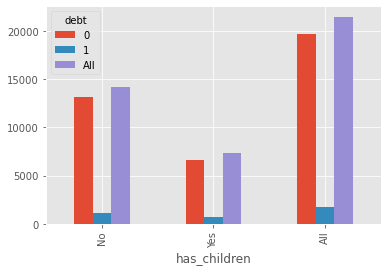

In [74]:
pivot_children_debt.plot(kind = 'bar')
plt.show()

In [75]:
t_h = pivot_children_debt.loc['Yes', 1]/pivot_children_debt.loc['Yes', 'All']
t_nh = pivot_children_debt.loc['No', 1]/pivot_children_debt.loc['No', 'All']
print(t_h)
t_nh

0.09188151398793198


0.07562491173563056

***Conclusiones***

* La tasa de impago en para el grupo que `tiene hijos` es `0.092`.

* La tasa de impago en para el grupo que `no tiene hijos` es `0.076`.

* Tener hijos representa un riesgo de impago `1.2` veces mayor que no tener hijos. 

**¿Existe una correlación entre la situación familiar y el pago a tiempo?**

In [76]:
pivot_married_debt = data_credit_scoring.pivot_table(index = 'married', columns = 'debt', values = 'children', aggfunc = 'count', margins = True)
pivot_married_debt

debt,0,1,All
married,,,
No,8305,810,9115
Yes,11408,931,12339
All,19713,1741,21454


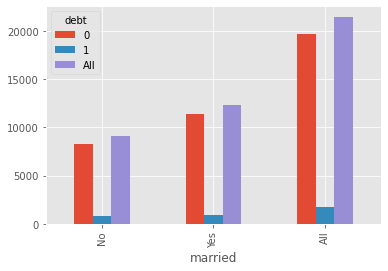

In [78]:
pivot_married_debt.plot(kind = 'bar')
plt.show()

In [79]:
t_m = pivot_married_debt.loc['Yes', 1]/pivot_married_debt.loc['Yes', 'All']
t_nm = pivot_married_debt.loc['No', 1]/pivot_married_debt.loc['No', 'All']
print(t_m)
print(t_nm)
t_nm/t_m

0.07545181943431396
0.08886450905101481


1.1777649593775208

***Conclusiones*** 

* La tasa de impago en el grupo de los `casados` es `0.75`. 

* La tasa de impago en el grupo de los `no casados` es `0.89`. 

* No estar casado representa un riesgo de impago `1.18` veces mayor que estarlo.


**¿Existe una correlación entre el nivel de ingresos y el pago a tiempo?**

In [80]:
pivot_income_debt = data_credit_scoring.pivot_table(index = 'income_group', columns = 'debt', values = 'children', aggfunc = 'count', margins = True)
pivot_income_debt

debt,0,1,All
income_group,,,
high_income,4990,374,5364
low_income,4938,426,5364
medium_income,9785,941,10726
All,19713,1741,21454


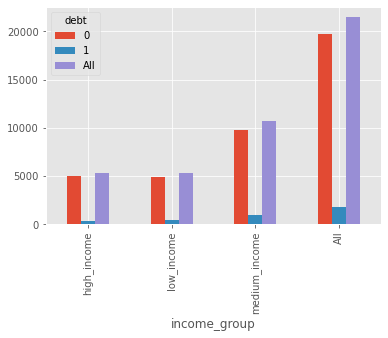

In [82]:
pivot_income_debt.plot(kind = 'bar')
plt.show()

In [83]:
t_hi = pivot_income_debt.loc['high_income',1]/pivot_income_debt.loc['high_income','All']
print(t_hi)
t_li = pivot_income_debt.loc['low_income',1]/pivot_income_debt.loc['low_income','All']
print(t_li)
t_mi = pivot_income_debt.loc['medium_income',1]/pivot_income_debt.loc['medium_income','All']
t_mi

0.06972408650260999
0.07941834451901567


0.0877307477158307

In [84]:
print(t_mi/t_hi)
t_mi/t_li

1.2582559645660853


1.1046660346190513

***Conclusiones***

* La tasa de impago en el grupo de los que tienen `altos ingresos` es `0.07`.

* La tasa de impago en el grupo de los que tienen `bajos ingresos` es `0.08`.

* La tasa de impago en el grupo de los que tienen `ingresos medios` es `0.09`.

* Es `1.3` más probable el inpago a tiempo si el solicitante es de `ingreso medio` que si es de `ingreso alto` y `1.1` que si es de `ingreso bajo`. 

**¿Cómo afecta el propósito del crédito a la tasa de incumplimiento?**

In [85]:
pivot_purpose_debt = data_credit_scoring.pivot_table(index = 'purpose_group', columns = 'debt', values = 'children', aggfunc = 'count', margins = True)
pivot_purpose_debt

debt,0,1,All
purpose_group,,,
car,3903,403,4306
education_purpose,3643,370,4013
house,3553,256,3809
real_estate,6476,526,7002
wedding,2138,186,2324
All,19713,1741,21454


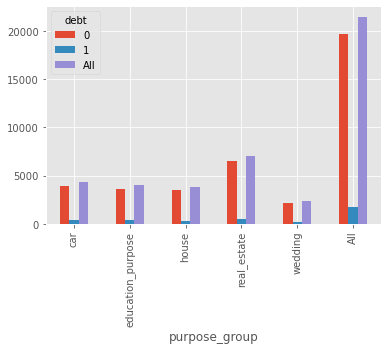

In [87]:
pivot_purpose_debt.plot(kind = 'bar')
plt.show()

In [88]:
t_c = pivot_purpose_debt.loc['car',1]/pivot_purpose_debt.loc['car','All']
print(t_c)
t_edu = pivot_purpose_debt.loc['education_purpose',1]/pivot_purpose_debt.loc['education_purpose','All']
print(t_edu)
t_hou = pivot_purpose_debt.loc['house',1]/pivot_purpose_debt.loc['house','All']
print(t_hou)
t_rs = pivot_purpose_debt.loc['real_estate',1]/pivot_purpose_debt.loc['real_estate','All']
print(t_rs)
t_w = pivot_purpose_debt.loc['wedding',1]/pivot_purpose_debt.loc['wedding','All']
print(t_w)

0.09359033906177427
0.0922003488661849
0.06720924127067472
0.07512139388746072
0.08003442340791739


In [89]:
print(t_c/t_rs)
t_c/t_hou

1.2458546656093983


1.3925218808058524

***Conclusiones***

* La tasa de impago para los que piden crédito para `coche` es de `0.094`.

* La tasa de impago para los que piden crédito para `educación` es de `0.092`.

* La tasa de impago para los que piden crédito para `casa` es de `0.067`.

* La tasa de impago para los que piden crédito para `bienes raíces` es de `0.075`.

* La tasa de impago para los que piden crédito para `boda` es de `0.08`.

* **Es `1.4` más probable el impago a tiempo cuando el crédito es para `coche` que cuando se solicita para `casa`, `1.2` más que cuando se solicita para `bienes raíces`.**

## Conclusiones generales del estudio

***Estrategia seguida***

1. En este proyecto nos planteamos responder como algunas características sociales de los clientes, como `estatus familiar`, `edad`, `nivel escolar` y `nivel de ingresos`, influyen en la probabilidad de no pagar a tiempo el crédito solicitado. 

2. Se utilizó una base de datos con `21565` observaciones en la cual se presentaban `2` variables numéricas con valores ausentes, `days_employed` y `total_income`. Los valores ausentes se presentaban en ambas columnas en las mismas filas. Después de un estudio de la distribución de los mismos llegamos a la conclusión que **las filas con valores ausentes en estas columnas se asociaban a clientes de ingresos bajos y alta antiguedad.** 

3. Los valores ausentes se sustituyeron por `las medianas` de las variables con valores ausentes tomadas por categorías asociadas a variables que representan carácteristicas que pueden influir en estos valores.

4. Algunas columnas también presentaban problemas de valores no válidos, los cuales también fueron resueltos. 

5. Finalmente, se agregaron `cinco columnas` representando variables categóricas que agrupan de manera más concisa las variables a considerar en relación con la probabilidad de inpago a tiempo. 

***Resultado obtenidos***

Construimos `tablas cruzadas` para establecer una posible correlación entre la variable `debt` y las cinco variables `purpose_group`, `has_children`, `married` y `income_group`.

1. Tener hijos `aumenta` la propabilidad de no pagar a tiempo. 

2. Ser casado `disminuye` la probabilidad de no pagar a tiempo. 

3. Las personas que piden créditos para `coches` y `educación` tienen más probabilidad de no pagar a tiempo.

4. Las personas con `ingresos medios` tiene `mayores` probabilidades de no pagar a tiempo.  